In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image

import cv2

import warnings
warnings.filterwarnings('ignore')


In [7]:
train_path = r"data/train"

In [11]:
train_datagen = ImageDataGenerator(
     rescale=1./255,
      rotation_range=20,
      shear_range=0.2,
      zoom_range=0.2,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')

In [14]:
train_ds = train_datagen.flow_from_directory(
        'data/train',
        color_mode="rgb",
    target_size = (331,331), 
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
        )

Found 2000 images belonging to 3 classes.


In [15]:
valid_ds = train_datagen.flow_from_directory(
  'data/valid',
  
  color_mode="rgb",
    target_size = (331,331), 
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42)

Found 150 images belonging to 3 classes.


In [16]:
x,y = next(train_ds)
x.shape 


(32, 331, 331, 3)

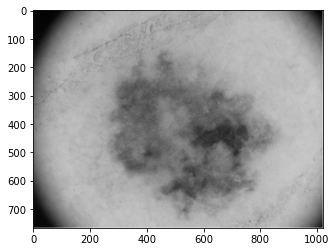

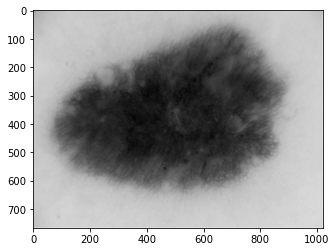

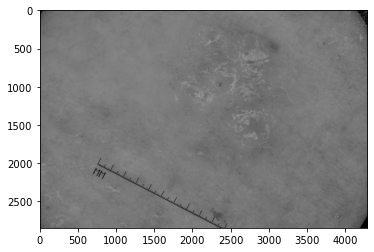

In [26]:
import os
import cv2
from tqdm import tqdm


DATADIR = "./data/train"

CATEGORIES = ["melanoma", "nevus","seborrheic_keratosis"]

for category in CATEGORIES: 
    path = os.path.join(DATADIR,category) 
    for img in os.listdir(path):  
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  

In [27]:

base_model = tf.keras.applications.InceptionResNetV2(
					include_top=False,
					weights='imagenet',
					input_shape=(331,331,3)
					)

base_model.trainable=False


model = tf.keras.Sequential([
		base_model,
		tf.keras.layers.BatchNormalization(renorm=True),
		tf.keras.layers.GlobalAveragePooling2D(),
		tf.keras.layers.Dense(512, activation='relu'),
		tf.keras.layers.Dense(256, activation='relu'),
		tf.keras.layers.Dropout(0.5),
		tf.keras.layers.Dense(128, activation='relu'),
		tf.keras.layers.Dense(3, activation='softmax')
	])


In [28]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [29]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 9, 9, 1536)        54336736  
_________________________________________________________________
batch_normalization_203 (Bat (None, 9, 9, 1536)        10752     
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               786944    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3

In [30]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                        min_delta=0.001,
                                        restore_best_weights=True)



In [35]:
batch_size=32
STEP_SIZE_TRAIN = train_ds.n//train_ds.batch_size
STEP_SIZE_VALID = valid_ds.n//valid_ds.batch_size


history = model.fit(train_ds,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_ds,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25,
                    callbacks=[early])


Epoch 1/25
62/62 [==============================] - 375s 6s/step - loss: 0.8629 - accuracy: 0.6590 - val_loss: 0.9129 - val_accuracy: 0.5859
Epoch 2/25
62/62 [==============================] - 352s 6s/step - loss: 0.7220 - accuracy: 0.6997 - val_loss: 0.9487 - val_accuracy: 0.5703
Epoch 3/25
62/62 [==============================] - 356s 6s/step - loss: 0.6814 - accuracy: 0.7144 - val_loss: 0.7620 - val_accuracy: 0.6875
Epoch 4/25
62/62 [==============================] - 360s 6s/step - loss: 0.6911 - accuracy: 0.7165 - val_loss: 0.8394 - val_accuracy: 0.5781
Epoch 5/25
62/62 [==============================] - 363s 6s/step - loss: 0.6618 - accuracy: 0.7322 - val_loss: 0.7456 - val_accuracy: 0.6719
Epoch 6/25
62/62 [==============================] - 356s 6s/step - loss: 0.6185 - accuracy: 0.7444 - val_loss: 0.7505 - val_accuracy: 0.6484
Epoch 7/25
62/62 [==============================] - 348s 6s/step - loss: 0.6049 - accuracy: 0.7490 - val_loss: 0.7918 - val_accuracy: 0.6250
Epoch 8/25
62

In [36]:
model.save("Model.h5")


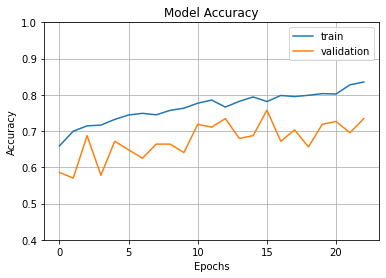

In [39]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()





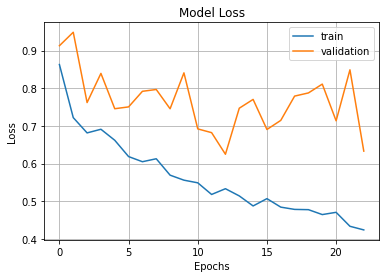

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [57]:
accuracy_score = model.evaluate(train_ds)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

print("Loss: ",accuracy_score[0])


63/63 [==============================] - 577s 9s/step - loss: 0.4692 - accuracy: 0.8010
[0.46918055415153503, 0.8009999990463257]
Accuracy: 80.1000%
Loss:  0.46918055415153503


In [54]:

inp = r"data/test/melanoma/ISIC_0014766.jpg"
#inp = r"data/train/melanoma/ISIC_0014543.jpg"

image=cv2.imread(inp)
image_resized= cv2.resize(image, (331,331))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)

(1, 331, 331, 3)


In [55]:
pred=model.predict(image)
print(pred)

[[0. 1. 0.]]


In [56]:
output_class=CATEGORIES[np.argmax(1-pred)]
print("The predicted class is", output_class)

The predicted class is melanoma
